In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from cvxpy import Variable, Minimize, quad_form, Problem
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import datetime
import os

In [ ]:
# load and prep price data for performance metric calcs later
price_data = pd.read_csv('/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/price_data.csv', index_col='Date')
price_data.index = pd.to_datetime(price_data.index)
price_data = price_data.resample('M').last()

In [ ]:
price_data

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-30,18.084864,19.452835,27.275208,18.042027,37.580696,6.986391,50.016724,19.713255,58.974018,23.594051,...,22.294102,42.033802,26.384897,44.983894,21.096275,39.203125,36.882957,13.126309,18.833063,39.692024
2010-05-31,16.812269,17.691553,25.709259,15.780361,35.440769,6.308457,44.987698,18.299448,55.058895,20.013325,...,21.984257,38.268177,21.934103,40.615334,19.939125,37.704403,31.742180,12.444481,17.708029,35.651131
2010-06-30,16.536545,18.076609,25.530659,15.199726,32.793289,6.520901,42.526512,18.245459,52.494289,17.627981,...,19.849804,41.733227,22.202362,36.778732,19.274620,33.998264,28.617540,11.831610,16.420986,33.652184
2010-07-31,17.510710,19.154768,26.171133,17.522261,36.022224,7.427565,47.624966,19.567991,53.410347,20.571100,...,19.838331,42.571770,24.214312,42.238750,20.893785,35.484879,31.093103,12.599545,16.427986,35.191193
2010-08-31,17.603472,21.678362,24.484312,16.930454,33.107098,6.975228,48.576427,19.321186,52.936806,19.738674,...,20.296064,40.805687,22.000530,39.050110,18.546015,35.548740,28.230707,12.413131,15.198378,35.104492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,101.338943,78.073082,250.369537,73.718094,197.084412,71.598656,289.688538,114.312759,276.244598,25.834913,...,270.494598,142.361816,389.202759,91.907471,68.223991,124.331741,108.506454,53.819466,406.219513,109.167885
2023-09-30,95.380722,74.253105,237.757019,75.873192,169.015213,65.307846,279.541229,104.434250,256.439728,24.045246,...,253.899780,120.715363,363.860657,82.094978,64.697701,108.631851,102.537682,52.932461,374.582520,115.441681
2023-10-31,93.631081,70.462677,215.659378,77.217659,126.015930,69.219376,278.594299,106.139816,250.736221,22.294189,...,237.135727,111.807304,347.828918,83.538857,65.633568,108.847992,88.487267,54.084248,317.757751,103.924995


In [ ]:
n_train = 24
n_val = 6

In [ ]:
sorted_index = sorted(price_data.index.unique())
# let's establish train, validation, and test periods here:
trainval_date_index = sorted_index[:-n_val]
test_date_index = sorted_index[-n_val:]

train_prices = price_data[price_data.index.isin(trainval_date_index)]
train_prices = train_prices.sort_index()
test_prices = price_data[price_data.index.isin(test_date_index)]
test_prices = test_prices.sort_index()

In [ ]:
train_prices

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-30,18.084864,19.452835,27.275208,18.042027,37.580696,6.986391,50.016724,19.713255,58.974018,23.594051,...,22.294102,42.033802,26.384897,44.983894,21.096275,39.203125,36.882957,13.126309,18.833063,39.692024
2010-05-31,16.812269,17.691553,25.709259,15.780361,35.440769,6.308457,44.987698,18.299448,55.058895,20.013325,...,21.984257,38.268177,21.934103,40.615334,19.939125,37.704403,31.742180,12.444481,17.708029,35.651131
2010-06-30,16.536545,18.076609,25.530659,15.199726,32.793289,6.520901,42.526512,18.245459,52.494289,17.627981,...,19.849804,41.733227,22.202362,36.778732,19.274620,33.998264,28.617540,11.831610,16.420986,33.652184
2010-07-31,17.510710,19.154768,26.171133,17.522261,36.022224,7.427565,47.624966,19.567991,53.410347,20.571100,...,19.838331,42.571770,24.214312,42.238750,20.893785,35.484879,31.093103,12.599545,16.427986,35.191193
2010-08-31,17.603472,21.678362,24.484312,16.930454,33.107098,6.975228,48.576427,19.321186,52.936806,19.738674,...,20.296064,40.805687,22.000530,39.050110,18.546015,35.548740,28.230707,12.413131,15.198378,35.104492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,99.202927,77.492058,213.700516,66.565643,251.314957,64.263275,276.957092,109.807426,230.129364,27.834009,...,219.279205,143.249008,338.106781,81.735008,72.094292,163.035339,106.142273,46.506504,316.178314,106.112984
2023-03-31,98.754311,77.550468,217.657974,63.020039,218.845078,67.709976,279.899384,109.369400,243.817749,25.735476,...,222.667221,152.431503,341.644409,77.644524,74.665985,160.258438,107.963516,48.445019,345.539276,105.871620
2023-04-30,108.274826,76.012306,215.086731,68.226128,183.618393,67.166405,286.867371,111.102028,260.335602,25.678158,...,235.317719,149.564392,359.292969,83.194695,74.662857,152.633972,107.418449,49.601521,360.453674,114.251747


In [ ]:
rets_m = np.log(price_data).diff()
rets_m = rets_m.dropna()
rets_m

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-31,-0.072966,-0.094906,-0.059127,-0.133938,-0.058628,-0.102073,-0.105968,-0.074420,-0.068694,-0.164596,...,-0.013996,-0.093855,-0.184749,-0.102159,-0.056413,-0.038980,-0.150103,-0.053341,-0.061596,-0.107369
2010-06-30,-0.016536,0.021531,-0.006971,-0.037489,-0.077639,0.033121,-0.056261,-0.002955,-0.047699,-0.126911,...,-0.102132,0.086679,0.012156,-0.099226,-0.033895,-0.103467,-0.103627,-0.050502,-0.075458,-0.057703
2010-07-31,0.057240,0.057933,0.024777,0.142195,0.093912,0.130186,0.113229,0.069979,0.017300,0.154400,...,-0.000578,0.019894,0.086745,0.138418,0.080663,0.042797,0.082966,0.062886,0.000426,0.044718
2010-08-31,0.005283,0.123763,-0.066624,-0.034358,-0.084388,-0.062833,0.019781,-0.012693,-0.008906,-0.041307,...,0.022811,-0.042370,-0.095877,-0.078492,-0.119197,0.001798,-0.096576,-0.014906,-0.077798,-0.002467
2010-09-30,0.057113,0.035393,0.093478,0.090199,0.158387,0.119880,0.118052,0.033018,0.088371,0.104297,...,0.065444,0.034454,0.178699,0.139517,0.045279,0.043602,0.139387,0.065236,0.020316,0.044342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.078741,-0.063630,0.029293,0.036018,-0.066060,-0.001791,-0.032758,-0.042120,0.002975,-0.089377,...,-0.015221,-0.031164,-0.006967,-0.050514,-0.091321,-0.066932,-0.093746,0.020605,0.100376,0.044335
2023-09-30,-0.060594,-0.050166,-0.051689,0.028815,-0.153643,-0.091964,-0.035657,-0.090381,-0.074393,-0.071789,...,-0.063313,-0.164936,-0.067329,-0.112905,-0.053071,-0.134989,-0.056579,-0.016618,-0.081082,0.055879
2023-10-31,-0.018514,-0.052396,-0.097549,0.017565,-0.293580,0.058169,-0.003393,0.016200,-0.022492,-0.075611,...,-0.068307,-0.076659,-0.045060,0.017435,0.014362,0.001988,-0.147372,0.021526,-0.164523,-0.105096


In [ ]:
mvo_wts = pd.DataFrame()

for i in range(2, len(rets_m) - n_train + 1):
  rets_exp = rets_m.iloc[i : i + n_train, :].mean()
  rets_exp = rets_exp.values.reshape(1, -1)
  rets_cov = rets_m.iloc[i : i + n_train, :].cov()

  x = Variable(rets_m.shape[1])

  # return and risk in proper matrix form
  ret = rets_exp @ x
  risk = quad_form(x, rets_cov)

  # optimize with constraints (long-only and all weights sum to 1)
  prob = Problem(Minimize(risk), [sum(x)==1, x >= 0])

  prob.solve()

  weights = pd.DataFrame([x.value], columns=rets_m.columns).round(4).T.rename(columns={0:rets_m.index[i + n_train-1]}).T

  mvo_wts = pd.concat([mvo_wts, weights], axis=0)

In [ ]:
mvo_wts

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
2012-06-30,0.0,-0.0,0.0,-0.0,0.0000,-0.0000,0.0,-0.0,0.0000,0.0,...,0.0193,0.0000,-0.0,-0.0,0.0,0.0336,-0.0,-0.0000,0.1197,0.0
2012-07-31,-0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,-0.0,0.0000,0.0,...,0.0000,0.0000,-0.0,0.0,0.0,0.0391,0.0,0.0347,0.0788,-0.0
2012-08-31,-0.0,-0.0,0.0,0.0,0.0000,0.0000,0.0,-0.0,0.0000,0.0,...,-0.0000,0.0384,0.0,0.0,0.0,0.0485,0.0,0.0844,0.0246,-0.0
2012-09-30,-0.0,0.0,-0.0,-0.0,-0.0000,-0.0000,-0.0,0.0,-0.0000,-0.0,...,-0.0000,0.0237,0.0,-0.0,-0.0,0.0593,-0.0,0.0826,-0.0000,-0.0
2012-10-31,0.0,-0.0,0.0,0.0,0.0000,0.0313,0.0,-0.0,0.0000,0.0,...,0.0000,0.0363,-0.0,0.0,0.0,0.0803,0.0,0.0161,0.0000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.0,-0.0,0.0,0.0,0.0539,0.0000,0.0,0.0,0.0958,0.0,...,0.0000,0.4133,0.0,0.0,0.0,-0.0000,0.0,-0.0000,0.0000,0.0
2023-09-30,0.0,0.0,0.0,0.0,0.0536,0.0000,0.0,0.0,0.0243,0.0,...,0.0000,0.2058,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0219,0.0
2023-10-31,0.0,-0.0,-0.0,0.0,0.0487,0.0000,0.0,-0.0,0.0000,0.0,...,0.0000,0.1678,0.0,0.0,-0.0,0.0000,0.0,0.0066,-0.0000,0.0
2023-11-30,0.0,-0.0,-0.0,0.0,0.0504,0.0000,0.0,-0.0,0.0000,0.0,...,0.0000,0.1595,0.0,0.0,-0.0,0.0000,0.0,0.0543,-0.0000,0.0


In [ ]:
def perform_backtest(price_data, wts, initial_amount, timestamp, model_type):


  ind_rets = price_data.pct_change().dropna()
  portfolio_returns = (ind_rets * wts.iloc[1:,:]).sum(axis=1)
  p_rets = pd.DataFrame({model_type: portfolio_returns})

  cumulative_rets = (1 + portfolio_returns).cumprod()
  wealth_index = initial_amount * cumulative_rets

  sharpeRatio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(12)
  totalReturn = wealth_index[-1] / wealth_index[0] - 1
  years = len(portfolio_returns) / 12
  annualReturn = (wealth_index[-1]/wealth_index[0])**(1 / years) - 1
  volatility = portfolio_returns.std() * np.sqrt(12)
  maxDrawdown = (cumulative_rets / cumulative_rets.cummax() - 1).min()


  p_metrics = pd.DataFrame({f'{model_type}':[totalReturn, annualReturn, sharpeRatio, volatility, maxDrawdown]})
  p_metrics.index = ['totalReturn', 'annualReturn', 'sharpeRatio', 'volatility', 'maxDrawdown']

  return p_metrics, p_rets

In [ ]:
def plot_wealth_index(portfolio_returns, initial_amount, timestamp, model_version, root_dir):
    # need to insert a row of 0s at the beginning so each line starts at the initial amount
    first_date = portfolio_returns.index[0]
    previous_month_end = first_date - relativedelta(months=1)
    new_row_values = [0] * len(portfolio_returns.columns)
    portfolio_returns = pd.concat([pd.DataFrame([new_row_values], columns=portfolio_returns.columns, index=[previous_month_end]), portfolio_returns], axis=0)

    # now calculate cumulative rets and wealth index
    cumulative_rets = (1 + portfolio_returns).cumprod()
    wealth_index = initial_amount * cumulative_rets

    plt.figure(figsize=(10, 6))
    for column in wealth_index.columns:
        plt.plot(wealth_index.index, wealth_index[column], label=column)

    plt.xlabel('Date')
    plt.ylabel('Wealth Index')
    plt.title('Wealth Index Over Time')
    plt.legend()
    plt.grid(True)

    plt.savefig(os.path.join(root_dir, f'mvo_wealth_index_{model_version}_{timestamp}.png'))

In [ ]:
timestamp = '20240517'
initial_amount = 1000

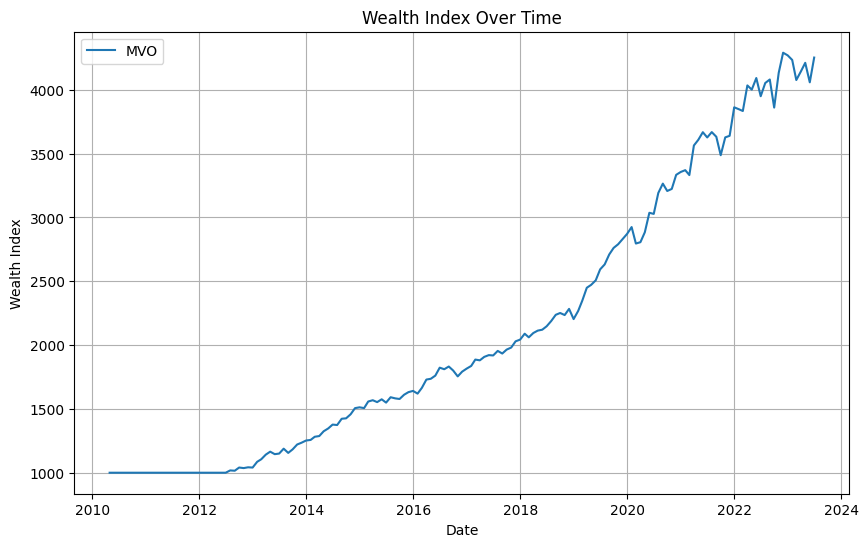

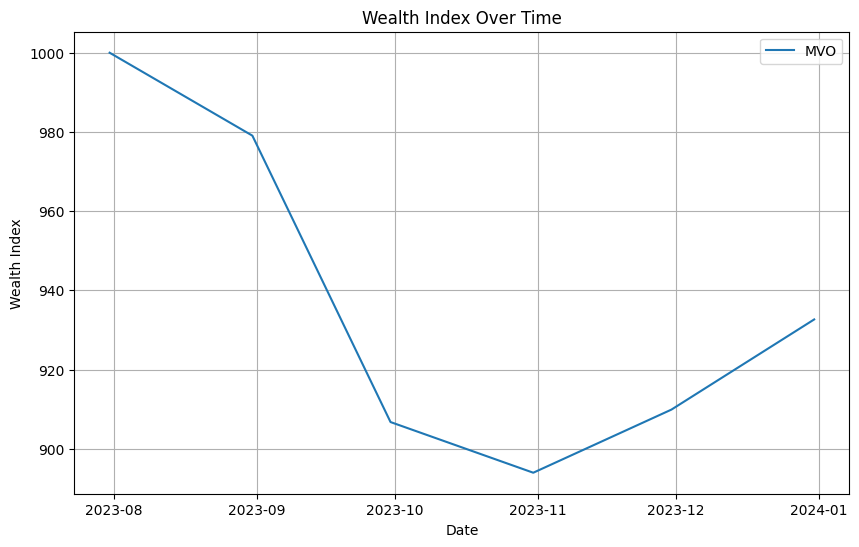

In [ ]:
for sample in ['train', 'test']:
  if sample == 'train':
    prices = train_prices
    wts = mvo_wts.iloc[:-n_val, :]
  elif sample == 'test':
    prices = test_prices
    wts = mvo_wts.iloc[-n_val:, :]

  mvo_metrics, mvo_rets = perform_backtest(prices, wts, initial_amount, timestamp, 'MVO')
  mvo_rets.index.name = 'Date'

  os.makedirs(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/{timestamp}/", exist_ok=True)

  mvo_metrics.to_csv(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/{timestamp}/{sample}_mvo_metrics.csv")
  mvo_rets.to_csv(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/{timestamp}/{sample}_mvo_rets.csv")
  wts.to_csv(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/{timestamp}/{sample}_mvo_wts.csv")

  plot_wealth_index(mvo_rets, initial_amount, timestamp, sample, f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/{timestamp}/")

In [ ]:
mvo_metrics

,MVO
totalReturn,3.252779
annualReturn,0.116214
sharpeRatio,1.585795
volatility,0.071222
maxDrawdown,-0.056548


In [ ]:
mvo_rets

,MVO
Date,
2023-08-31,-0.020944
2023-09-30,-0.073871
2023-10-31,-0.014112
2023-11-30,0.017830
2023-12-31,0.025025


In [ ]:
wts

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
2023-07-31,0.0,-0.0,0.0,0.0,0.0627,0.0,0.0,0.0,0.0797,0.0,...,0.0,0.4302,0.0,0.0,0.0,-0.0,0.0,-0.0000,0.0000,0.0
2023-08-31,0.0,-0.0,0.0,0.0,0.0539,0.0,0.0,0.0,0.0958,0.0,...,0.0,0.4133,0.0,0.0,0.0,-0.0,0.0,-0.0000,0.0000,0.0
2023-09-30,0.0,0.0,0.0,0.0,0.0536,0.0,0.0,0.0,0.0243,0.0,...,0.0,0.2058,0.0,0.0,0.0,0.0,0.0,0.0000,0.0219,0.0
2023-10-31,0.0,-0.0,-0.0,0.0,0.0487,0.0,0.0,-0.0,0.0000,0.0,...,0.0,0.1678,0.0,0.0,-0.0,0.0,0.0,0.0066,-0.0000,0.0
2023-11-30,0.0,-0.0,-0.0,0.0,0.0504,0.0,0.0,-0.0,0.0000,0.0,...,0.0,0.1595,0.0,0.0,-0.0,0.0,0.0,0.0543,-0.0000,0.0
2023-12-31,-0.0,0.0,0.0,-0.0,0.0094,0.0,-0.0,0.0,0.0000,0.0,...,0.0,0.0841,0.0,-0.0,0.0,0.0,0.0,0.0200,0.0000,0.0


In [ ]:
wts.index.name = 'date'

In [ ]:
mean_mvo_test_wts = pd.DataFrame(wts.mean().sort_values(ascending=False), columns=['Weight'])
mean_mvo_test_wts.to_csv(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/{timestamp}/mean_MVO_test_wts.csv")

In [ ]:
# Assuming df is your DataFrame with time series data
# # Set the index of the DataFrame to the date column
# wts.set_index('date', inplace=True)

# Use idxmax() along axis=1 to get the index of the maximum value for each row
max_column = wts.idxmax(axis=1)

# Use max() along axis=1 to get the maximum value for each row
max_value = wts.max(axis=1)

# Combine the results into a new DataFrame or Series
result = pd.DataFrame({'max_value': max_value, 'max_column': max_column})

# Reset index to have 'date' as a column
result.reset_index(inplace=True)

In [ ]:
result.to_csv(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/{timestamp}/max_MVO_wts.csv")